In [1]:
!pip install kaggle



In [2]:
from google.colab import files
files.upload()  # Select kaggle.json from your local system


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sumanthsraj","key":"c1ececa92476050248e91cfa6d1e229e"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d jangedoo/utkface-new


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:18<00:00, 22.5MB/s]
100% 331M/331M [00:18<00:00, 19.1MB/s]


In [5]:
!unzip utkface-new.zip -d /content/utkface


Streaming output truncated to the last 5000 lines.
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  in

In [11]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Load Data
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])

# Shuffle Data
np.random.seed(10)
np.random.shuffle(filenames)

# Extract Age, Gender, and Race Labels
age_labels, gender_labels, race_labels, image_path = [], [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

# Create DataFrame
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, age_labels, gender_labels, race_labels
df = df[df['race'].isin(['0', '1', '2', '3', '4'])]

# Map Gender and Race
gender_dict = {0: "Male", 1: "Female"}
race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

# Splitting Data
train, test = train_test_split(df, train_size=0.8, random_state=42)

# Data Generator for Efficient Loading and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Update in the data generator to use 224x224
def custom_generator(dataframe, directory, batch_size, subset=None):
    generator = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    generator = generator.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col="image",
        y_col=None,
        target_size=(224, 224),  # Set to 224x224
        batch_size=batch_size,
        class_mode=None,
        shuffle=True,
        subset=subset
    )

    while True:
        # Get the batch of images
        batch_images = next(generator)

        # Get the indices for the current batch
        batch_indices = generator.index_array[:batch_size]  # Limit to batch_size

        # Select the labels for only the current batch using the batch indices
        batch_labels = dataframe.iloc[batch_indices]

        # Extract gender, age, and race labels
        gender = batch_labels['gender'].values
        age = batch_labels['age'].values
        race = to_categorical(batch_labels['race'].values, num_classes=5)

        # Ensure labels have consistent shapes
        gender = np.expand_dims(gender, axis=1)
        age = np.expand_dims(age, axis=1)

        # Yield only complete batches
        if len(batch_images) == batch_size:
            yield batch_images, {"gender_output": gender, "age_output": age, "race_output": race}

# Set batch size
batch_size = 32

# Train and Validation Generators
train_generator = custom_generator(train, str(path), batch_size=batch_size, subset="training")
validation_generator = custom_generator(train, str(path), batch_size=batch_size, subset="validation")
test_generator = custom_generator(test, str(path), batch_size=batch_size)

# Model Architecture - Using VGG16 with 224x224 input size
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in VGG16
for layer in conv_base.layers:
    layer.trainable = False

inputs = Input((224, 224, 3))  # Use 224x224 input size
X = conv_base(inputs)
X = Flatten()(X)

from tensorflow.keras.regularizers import l2

# Shared representation dense layer (256 nodes)
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)  # Change Dropout to 0.4

# Task-specific layers (gender, age, race)
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

from tensorflow.keras.optimizers import Adam

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss={
                  'gender_output': 'binary_crossentropy',
                  'age_output': 'mean_squared_error',
                  'race_output': 'categorical_crossentropy'
              },
              metrics={
                  'gender_output': 'accuracy',
                  'age_output': 'mean_absolute_error',
                  'race_output': 'accuracy'
              })

# Training the Model with Data Generators
checkpoint = ModelCheckpoint('best_model_by_race_output.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(test) // batch_size,
    callbacks=[checkpoint, early_stopping]
)


Num GPUs Available:  1
23708
['3_0_0_20170110225025587.jpg.chip.jpg', '22_1_3_20170104231706746.jpg.chip.jpg', '1_1_2_20161219195732971.jpg.chip.jpg']
Found 17068 validated image filenames.
Epoch 1/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - age_output_mean_absolute_error: 19.2583 - gender_output_accuracy: 0.5275 - loss: 688.1909 - race_output_accuracy: 0.4384Found 1896 validated image filenames.

Epoch 1: val_loss improved from inf to 462.47159, saving model to best_model_by_race_output.keras
592/592 ━━━━━━━━━━━━━━━━━━━━ 109s 173ms/step - age_output_mean_absolute_error: 19.2529 - gender_output_accuracy: 0.5275 - loss: 687.8530 - race_output_accuracy: 0.4384 - val_age_output_mean_absolute_error: 15.9156 - val_gender_output_accuracy: 0.5422 - val_loss: 462.4716 - val_race_output_accuracy: 0.3748
Epoch 2/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - age_output_mean_absolute_error: 10.4326 - gender_output_accuracy: 0.5500 - loss: 194.4274 - race_output_accuracy: 0.5244
Epoch 2: val_

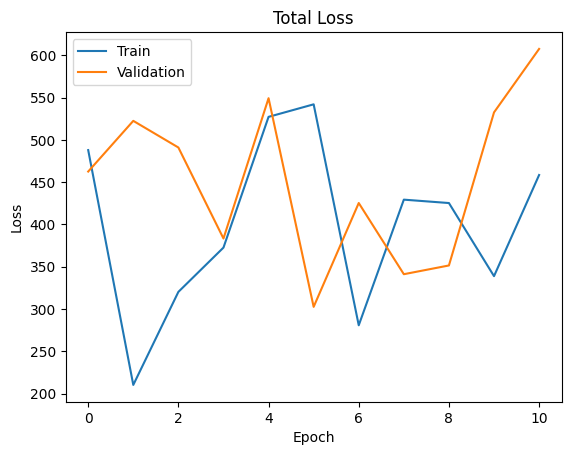

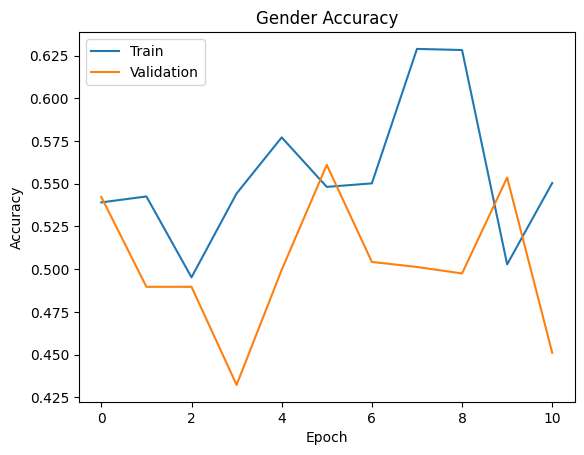

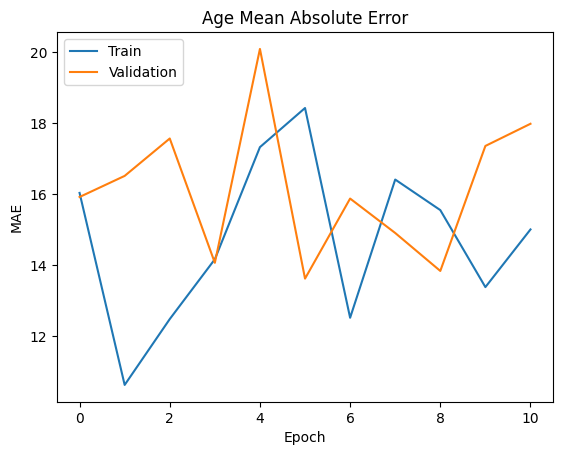

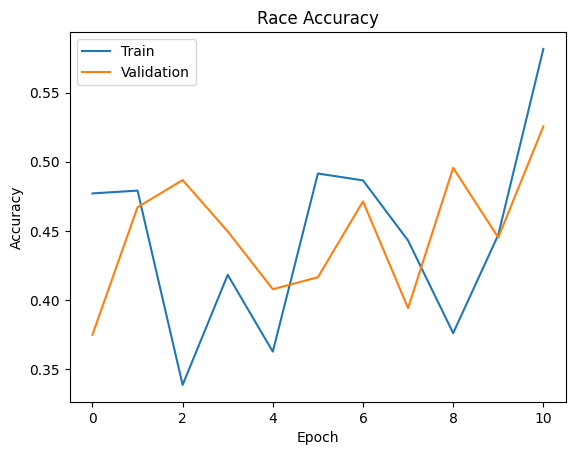

In [12]:
# Visualizing Losses
# Plot Combined Loss (total loss across all outputs)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Gender Accuracy
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Age Mean Absolute Error
plt.plot(history.history['age_output_mean_absolute_error'])
plt.plot(history.history['val_age_output_mean_absolute_error'])
plt.title('Age Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Race Accuracy
plt.plot(history.history['race_output_accuracy'])
plt.plot(history.history['val_race_output_accuracy'])
plt.title('Race Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()





In [14]:
# Load the best model
model = tf.keras.models.load_model('best_model_by_race_output.keras')

# Step 1: Preprocess the test data (ensure the same preprocessing as used during training)
# The test_generator already handles this with rescale and augmentation.

# Initialize empty lists for actual and predicted values
actual_gender, actual_age, actual_race = [], [], []
pred_gender, pred_age, pred_race = [], [], []

# Get predictions from the test generator
for batch_images, batch_labels in test_generator:
    # Extract actual labels from the generator
    actual_gender_batch = batch_labels['gender_output']
    actual_age_batch = batch_labels['age_output']
    actual_race_batch = batch_labels['race_output']

    # Store actual labels in the lists
    actual_gender.extend(actual_gender_batch)
    actual_age.extend(actual_age_batch)
    actual_race.extend(np.argmax(actual_race_batch, axis=1))  # Convert one-hot to categorical for race

    # Predict using the model
    predictions = model.predict(batch_images)

    # Store predicted labels in the lists
    pred_gender.extend(predictions[0])
    pred_age.extend(predictions[1])
    pred_race.extend(np.argmax(predictions[2], axis=1))  # Convert one-hot to categorical for race

    # Stop the loop when enough data is collected (matches test data size)
    if len(actual_gender) >= len(test):
        break

# Convert actual and predicted labels to numpy arrays for consistency
actual_gender = np.array(actual_gender[:len(test)])  # Trim excess if any
actual_age = np.array(actual_age[:len(test)])
actual_race = np.array(actual_race[:len(test)])

pred_gender = np.array(pred_gender[:len(test)])
pred_age = np.array(pred_age[:len(test)])
pred_race = np.array(pred_race[:len(test)])

# Step 5: Create a DataFrame with predictions and actual values to analyze
df_pred = pd.DataFrame({
    'Actual Gender': actual_gender.flatten(),
    'Predicted Gender': np.round(pred_gender).flatten(),  # Ensure binary values for gender
    'Actual Age': actual_age.flatten(),
    'Predicted Age': np.round(pred_age).flatten(),  # Round predicted age for comparison
    'Actual Race': actual_race.flatten(),
    'Predicted Race': pred_race.flatten()
})

# Show the head of the DataFrame to check the data
print(df_pred.head())

# Optionally, analyze and visualize the results
df_pred['Gender Correct'] = df_pred['Actual Gender'] == df_pred['Predicted Gender']
df_pred['Age Difference'] = np.abs(df_pred['Actual Age'] - df_pred['Predicted Age'])
df_pred['Race Correct'] = df_pred['Actual Race'] == df_pred['Predicted Race']

# Visualizing the accuracy for gender and race
print("Gender accuracy:", df_pred['Gender Correct'].mean())
print("Average age prediction error:", df_pred['Age Difference'].mean())
print("Race accuracy:", df_pred['Race Correct'].mean())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━